In [1]:
# !pip install datasets
import matplotlib as plt
import os
import random
from collections import Counter
from datasets import load_dataset
import matplotlib.pyplot as plt
import itertools 
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from PIL import ImageChops
from concurrent.futures import ProcessPoolExecutor
import cv2

In [2]:
# Set these at the very top of your script or notebook cell, before any other imports
os.environ["HF_HOME"] = "/mnt/datassd0/chest-xray/huggingface"
os.environ["HF_DATASETS_CACHE"] = "/mnt/datassd0/chest-xray/huggingface_cache"
os.environ["TMPDIR"] = "/mnt/datassd0/chest-xray/tmp"  # Also redirect temporary files if needed
os.makedirs(os.environ["HF_DATASETS_CACHE"], exist_ok=True)
os.makedirs(os.environ["TMPDIR"], exist_ok=True)

from datasets import load_dataset

dataset = load_dataset(
    "/mnt/datassd0/chest-xray/NIH-Chest-X-ray-dataset.py",
    name="image-classification",
    trust_remote_code=True,
    cache_dir="/mnt/datassd0/chest-xray/huggingface_cache"
)

In [3]:
# Print available splits and dataset info
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 86524
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 25596
    })
})


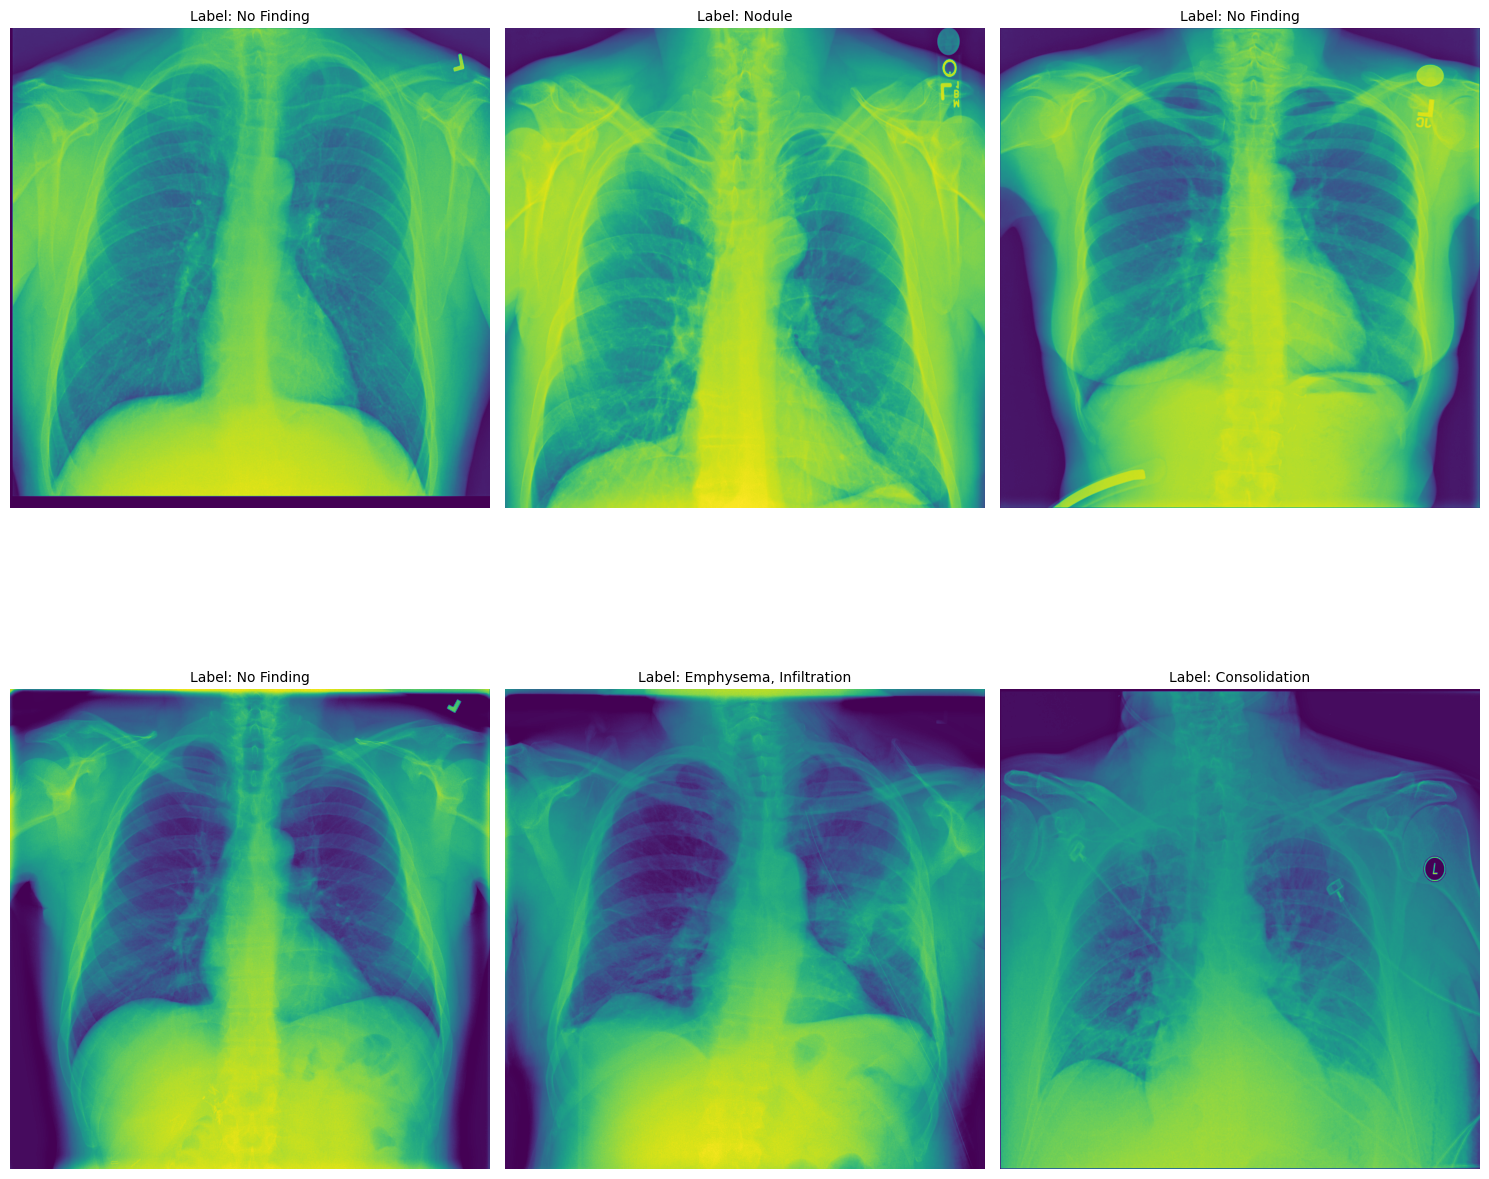

In [5]:
train_dataset = dataset["train"]

if "labels" in train_dataset.features:
    feature = train_dataset.features["labels"]
    if hasattr(feature, "feature") and hasattr(feature.feature, "names"):
        label_names = feature.feature.names

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 15))

for ax in axes.flat:
    # Pick a random sample from the dataset
    idx = random.randint(0, len(train_dataset) - 1)
    sample = train_dataset[idx]
    
    # Get the image and its labels (as a list)
    image = sample["image"]
    numeric_labels = sample["labels"]
    
    # Convert numeric labels to human-readable names if mapping exists
    if label_names:
        labels_text = [label_names[label] for label in numeric_labels]
    else:
        labels_text = numeric_labels
        
    label_str = ", ".join(labels_text)
    
    # Display the image and set its title to the label names
    ax.imshow(image)
    ax.set_title(f"Label: {label_str}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

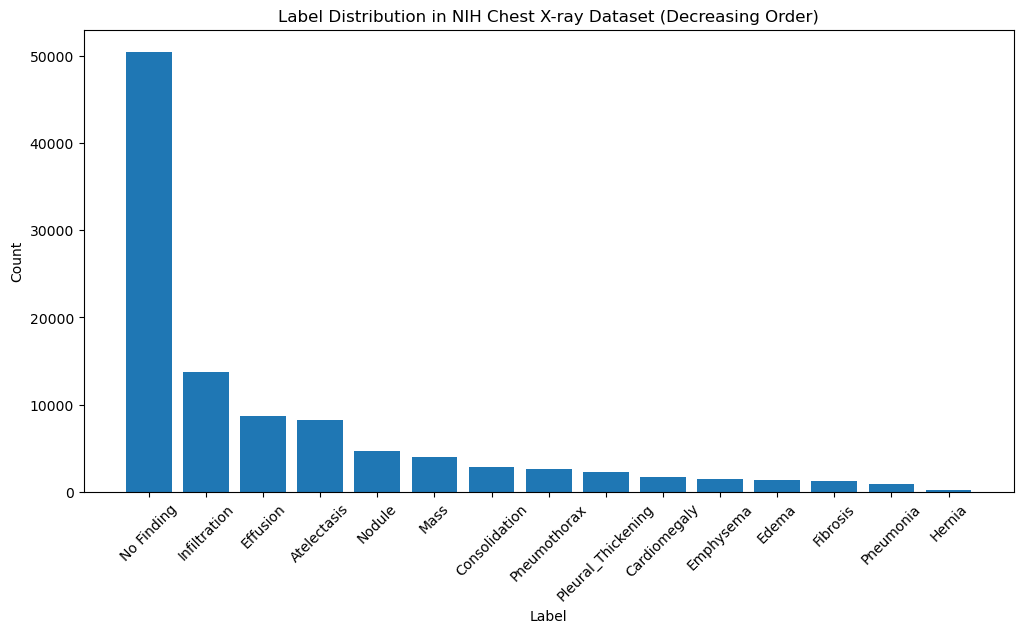

In [5]:
# Extract all labels from the dataset
if label_names:
    all_labels = [label_names[label] for label in itertools.chain.from_iterable(train_dataset["labels"])]
else:
    all_labels = list(itertools.chain.from_iterable(train_dataset["labels"]))

label_counts = Counter(all_labels)

# Sort the label counts in decreasing order
sorted_counts = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
labels_sorted, counts_sorted = zip(*sorted_counts)

# Create explicit x-axis positions
x_positions = np.arange(len(labels_sorted))

plt.figure(figsize=(12, 6))
plt.bar(x_positions, counts_sorted, align='center')
plt.xticks(x_positions, labels_sorted, rotation=45)
plt.title("Label Distribution in NIH Chest X-ray Dataset (Decreasing Order)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Counter({'No Finding': 50500, 'Finding': 36024})


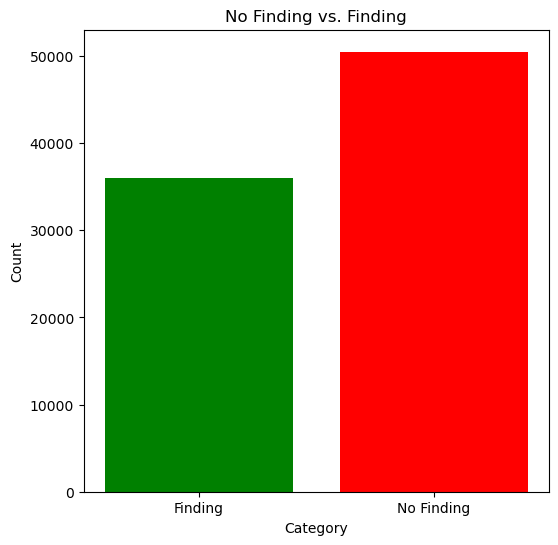

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Define a function that classifies each sample in a batch
def classify_finding(batch):
    groups = []
    for lab_list in batch["labels"]:
        # If the sample's labels is exactly [0], count it as "No Finding"
        if len(lab_list) == 1 and lab_list[0] == 0:
            groups.append("No Finding")
        else:
            groups.append("Finding")
    return {"finding_group": groups}

# Use the dataset's map function with batching and multiple processes
train_dataset = train_dataset.map(
    classify_finding, 
    batched=True, 
    batch_size=1000,  # adjust as needed for your hardware
    num_proc=4        # adjust according to available CPU cores
)

# Count the occurrences in the new "finding_group" column
group_counts = Counter(train_dataset["finding_group"])
print(group_counts)

# Plot a bar chart for "No Finding" vs "Finding"
labels_plot = list(group_counts.keys())
counts_plot = [group_counts[label] for label in labels_plot]

plt.figure(figsize=(6, 6))
plt.bar(labels_plot, counts_plot, color=["green", "red"])
plt.title("No Finding vs. Finding")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

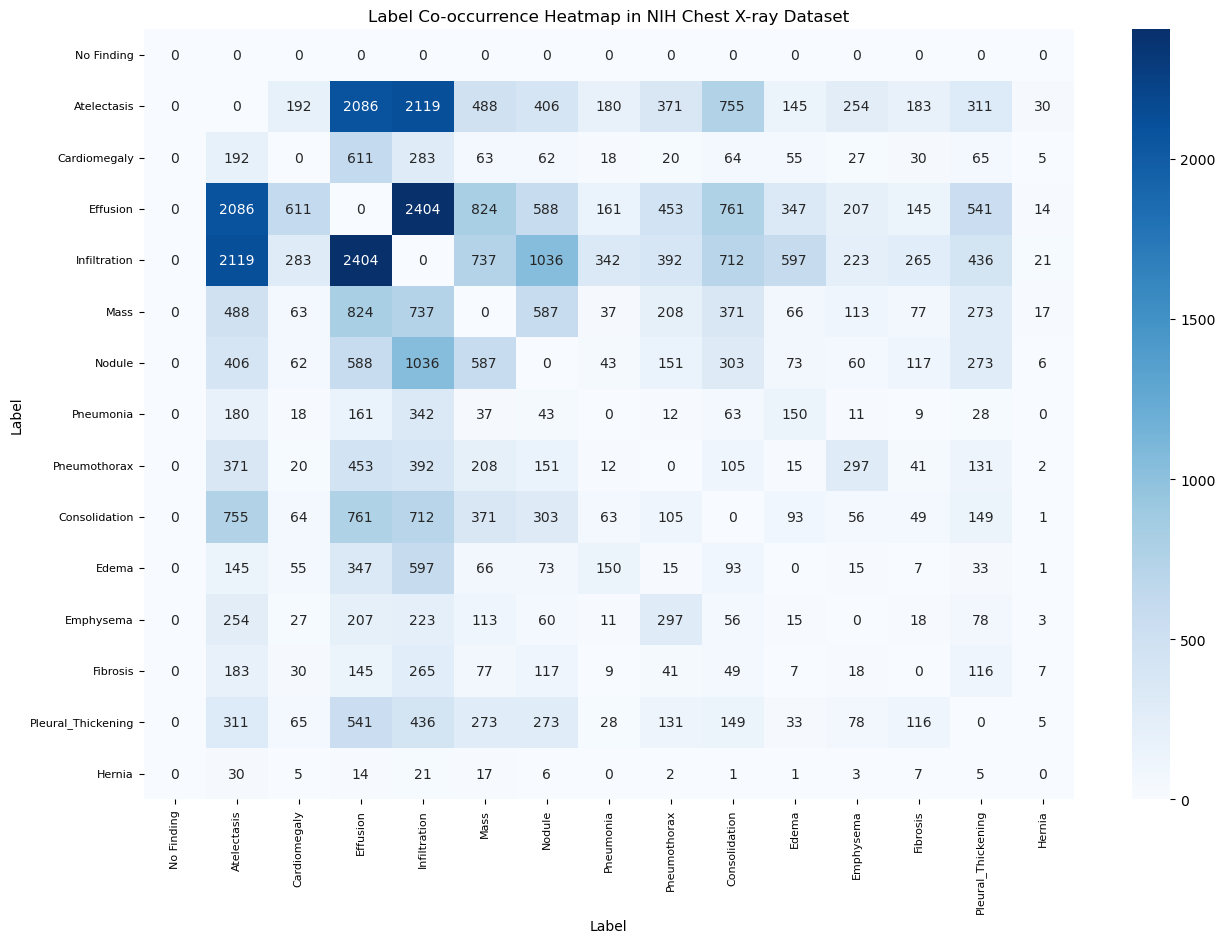

In [7]:
# Assuming 'train_dataset["labels"]' is a list of lists and 'label_names' exists.
labels_list = train_dataset["labels"]
num_samples = len(labels_list)
num_classes = len(label_names)  # since label_names is provided

# Create a binary matrix X: shape (num_samples, num_classes)
X = np.zeros((num_samples, num_classes), dtype=int)
for i, lab_list in enumerate(labels_list):
    # For each sample, mark the labels as 1
    X[i, lab_list] = 1

# Compute the co-occurrence matrix: X^T dot X gives a (num_classes x num_classes) matrix
co_matrix = np.dot(X.T, X)

# Remove self-co-occurrence by setting diagonal to 0
np.fill_diagonal(co_matrix, 0)

# Create a DataFrame with proper index and columns using label_names
co_occurrence_df = pd.DataFrame(co_matrix, index=label_names, columns=label_names)

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
ax = sns.heatmap(co_occurrence_df, cmap='Blues', annot=True, fmt="d")
ax.set_xticklabels(co_occurrence_df.columns, rotation=90, fontsize=8)
ax.set_yticklabels(co_occurrence_df.index, rotation=0, fontsize=8)
plt.title("Label Co-occurrence Heatmap in NIH Chest X-ray Dataset")
plt.xlabel("Label")
plt.ylabel("Label")
plt.show()

In [15]:
# Define a fast function to check image mode
def detect_grayscale(example):
    # The mode attribute is already available in the PIL image.
    # This function just returns True if the mode is "L" or "1".
    return {"is_gray": example["image"].mode in ("L")}

# Process the dataset in parallel (adjust num_proc based on available CPU cores)
train_dataset = train_dataset.map(detect_grayscale, num_proc=4)

# Count the results
gray_count = sum(train_dataset["is_gray"])
color_count = len(train_dataset) - gray_count

print(f"Grayscale images: {gray_count}")
print(f"Color images: {color_count}")

Map (num_proc=4):   0%|          | 0/86524 [00:00<?, ? examples/s]

Grayscale images: 86061
Color images: 463


In [ ]:
# Example threshold: if the centroid is more than 10% of the maximum offset away from the center, consider it distorted.
DISTORTION_THRESHOLD = 0.5

def detect_distortion(example, threshold_ratio=DISTORTION_THRESHOLD):
    # Convert image (a PIL.Image) to grayscale numpy array.
    img = np.array(example["image"].convert("L"))
    
    # Apply Otsu's thresholding to segment the image.
    # This yields a binary image where (typically) the x-ray content is white.
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find indices of white pixels (foreground)
    indices = np.argwhere(binary == 255)
    
    # If no foreground is detected, we can assume no significant content (or skip marking as distorted)
    if len(indices) == 0:
        distorted = False
    else:
        # Compute the centroid (row, col) of the foreground pixels.
        centroid = indices.mean(axis=0)
        h, w = img.shape
        center = np.array([h / 2, w / 2])
        offset = np.linalg.norm(centroid - center)
        
        # Maximum possible offset is half the diagonal of the image.
        max_offset = np.sqrt((h / 2) ** 2 + (w / 2) ** 2)
        normalized_offset = offset / max_offset
        
        distorted = normalized_offset > threshold_ratio
    
    # Add the result to the example.
    example["distorted"] = distorted
    return example

# Process the dataset in batches with multiple processes for efficiency.
train_dataset = train_dataset.map(detect_distortion, batched=False, num_proc=4)

# Count how many images are marked as distorted.
total_images = len(train_dataset)
distorted_count = sum(train_dataset["distorted"])
print(f"Total images: {total_images}")
print(f"Distorted images: {distorted_count}")

# # Get a few random distorted images.
# distorted_samples = [sample for sample in train_dataset if sample["distorted"]]
# non_distorted_samples = [sample for sample in train_dataset if not sample["distorted"]]

# print("Displaying some distorted images:")
# for sample in random.sample(distorted_samples, min(4, len(distorted_samples))):
#     plt.figure(figsize=(4, 4))
#     plt.imshow(sample["image"])
#     plt.title("Distorted")
#     plt.axis("off")
#     plt.show()

# print("Displaying some non-distorted images:")
# for sample in random.sample(non_distorted_samples, min(4, len(non_distorted_samples))):
#     plt.figure(figsize=(4, 4))
#     plt.imshow(sample["image"])
#     plt.title("Centered")
#     plt.axis("off")
#     plt.show()

Map (num_proc=4):   0%|          | 0/86524 [00:00<?, ? examples/s]

Total images: 86524
Distorted images: 48252


KeyboardInterrupt: 